In [1]:
from sklearn.preprocessing import StandardScaler
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score


class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()

    def scale_data(self, data):
        return self.scaler.fit_transform(data)

    def remove_outliers(self, df, feature, min1, max1):
        q = df[feature].quantile(min1)
        new_data = df[(df[feature] > q) & (df[feature] < df[feature].quantile(max1))]
        return new_data

    def preprocess_data(self, data, feature, min1, max1):
        scaled_data = self.scale_data(data)
        data["var"] = abs(
            abs(data["oldbalanceOrg"] - data["newbalanceOrig"])
            + abs(data["oldbalanceDest"] - data["newbalanceDest"])
            - data["amount"]
        )
        data['isFraud'] = data['isFraud'].map({1: 'yes', 0: 'no'})
        return self.remove_outliers(data, feature, min1, max1)

preprocessor = DataPreprocessor()
data_path = "fraud.csv"  
data = pd.read_csv(data_path)
numerical_data = data.select_dtypes(include=[np.number])

preprocessed_data = preprocessor.preprocess_data(numerical_data, "oldbalanceDest", 0.15, 0.85)


In [2]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [6]:
preprocessed_data.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'var'],
      dtype='object')

we lost most data because the fraud is a very under represented sample so we must not drop outliers but rather collect more data

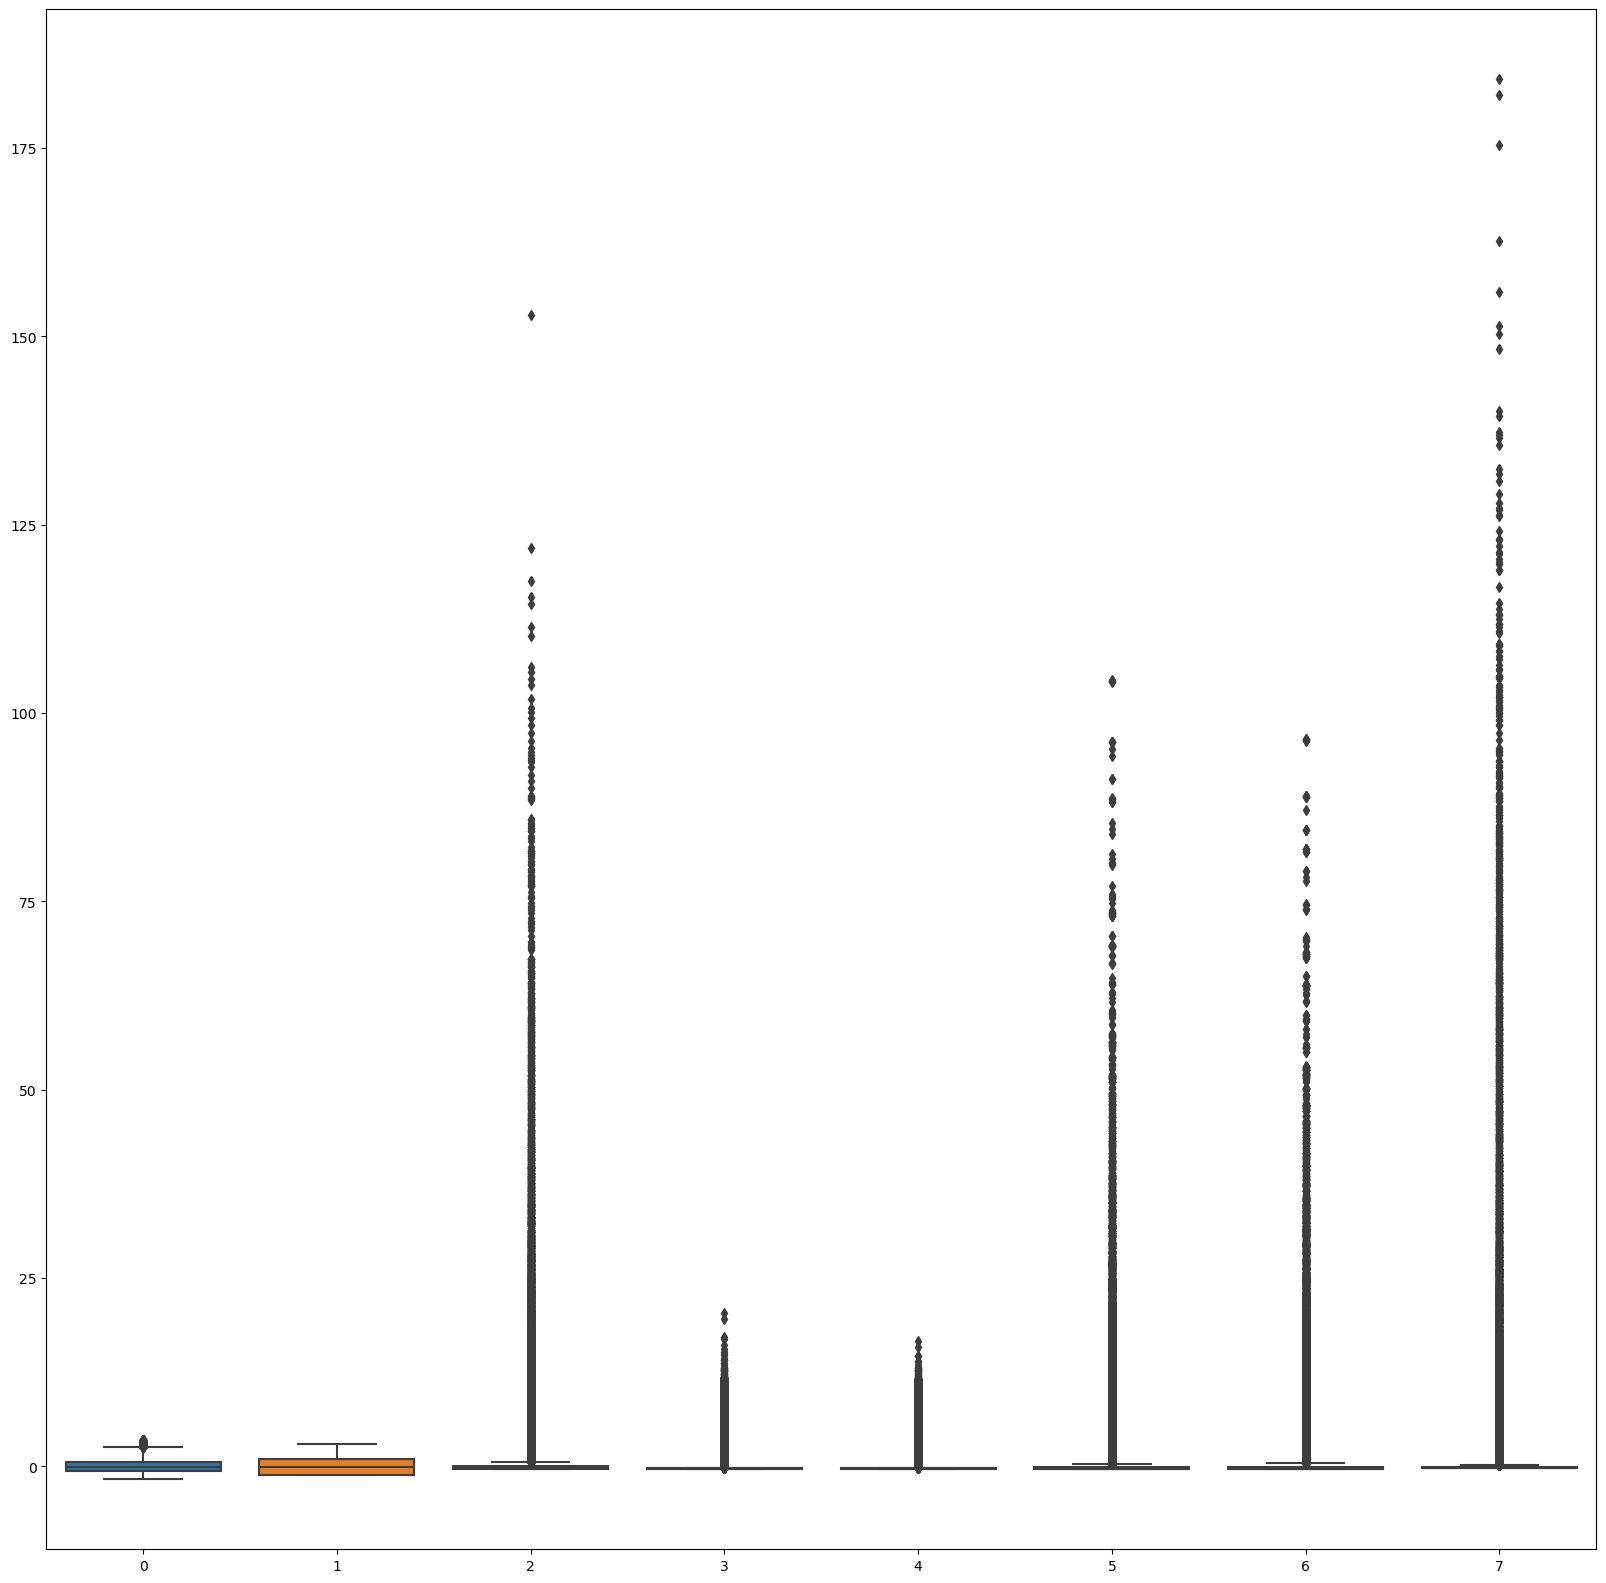

In [4]:
newData = data
newData.drop("nameOrig",axis =1,inplace = True)
newData.drop("nameDest",axis =1,inplace = True)
newData.drop("isFlaggedFraud",axis =1,inplace = True)
newData["var"] =abs(abs(newData["oldbalanceOrg"]-newData["newbalanceOrig"])+abs(newData["oldbalanceDest"]-newData["newbalanceDest"])-newData["amount"])
newData['isFraud'] = newData['isFraud'].map({1: 'yes', 0: 'no'})
newData['type'] = newData['type'].map({"CASH_OUT": 0,"PAYMENT":1,"CASH_IN":2,"TRANSFER":3,"DEBIT":4})
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
x = newData.drop(columns = 'isFraud', axis = 1)
y = newData.isFraud
x_scaled = scalar.fit_transform(x)
fig, ax = plt.subplots(figsize=(20,20))
sns.boxplot(data=x_scaled,ax=ax)
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
model2 = SVC()
from sklearn.neighbors import KNeighborsClassifier
model4 = KNeighborsClassifier()
from sklearn.ensemble import RandomForestClassifier
model6 = RandomForestClassifier(n_estimators=30)
from sklearn.linear_model import ElasticNet
model7 = ElasticNet(alpha=1.0, l1_ratio=0.5)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_scaled, y , test_size = .20, random_state=144,stratify=y)
def fit_predict(t):
    start_time = time.time()
    t.fit(x_train, y_train)
    end_time = time.time()
    print("Training time: ",end_time-start_time)
    start_time = time.time()
    y_test_predict = t.predict(x_test)
    end_time = time.time()
    print("Testing time: ",end_time-start_time)
    return y_test_predict  
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_mat(y_test,f):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
      confusion_matrix(y_test, f))
    cmp.plot(ax=ax)
    plt.show();
def accuracy(y_true, y_pred):
    correct_predictions = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:
            correct_predictions += 1
    print("accuracy = " + str(correct_predictions / len(y_true)))
from sklearn.metrics import recall_score, precision_score, f1_score
def metrics(y_test,y_pred):
    print("*********micro  *******")
    print('Recall : %.3f' % recall_score(y_test, y_pred,average='micro'))
    print('Precision: %.3f' % precision_score(y_test, y_pred,average='micro'))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred,average='micro'))
    print("*********macro  *******")
    print('Recall : %.3f' % recall_score(y_test, y_pred,average='macro'))
    print('Precision: %.3f' % precision_score(y_test, y_pred,average='macro'))
    print('F1 Score: %.3f' % f1_score(y_test, y_pred,average='macro'))
def evaluating_model(model,actual_val):
    print("name of the model ---  ")
    print(model)
    print("*****predicting values****")
    f = fit_predict(model)
    print()
    print("******evaluating model ****")
    accuracy(f,actual_val)
    print()
    metrics(f,actual_val)
    print()
    plot_mat(actual_val,f)
    print("********")    

In [49]:
evaluating_model(model1,y_test)

name of the model ---  
LogisticRegression()
*****predicting values****
Training time:  22.791462898254395
Testing time:  0.041669368743896484

******evaluating model ****
accuracy = 0.9992503088350396

*********micro  *******
Recall : 0.999
Precision: 0.999
F1 Score: 0.999
*********macro  *******
Recall : 0.958
Precision: 0.731
F1 Score: 0.807

********


C:\Users\Mukul\AppData\Local\Temp\ipykernel_3736\2106644985.py:44: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show();


In [50]:
newData

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,var
0,1,1,9839.64,170136.00,160296.36,0.00,0.00,no,1.455192e-11
1,1,1,1864.28,21249.00,19384.72,0.00,0.00,no,1.136868e-12
2,1,3,181.00,181.00,0.00,0.00,0.00,yes,0.000000e+00
3,1,0,181.00,181.00,0.00,21182.00,0.00,yes,2.118200e+04
4,1,1,11668.14,41554.00,29885.86,0.00,0.00,no,0.000000e+00
...,...,...,...,...,...,...,...,...,...
6362615,743,0,339682.13,339682.13,0.00,0.00,339682.13,yes,3.396821e+05
6362616,743,3,6311409.28,6311409.28,0.00,0.00,0.00,yes,0.000000e+00
6362617,743,0,6311409.28,6311409.28,0.00,68488.84,6379898.11,yes,6.311409e+06
6362618,743,3,850002.52,850002.52,0.00,0.00,0.00,yes,0.000000e+00


In [51]:
param = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C' : [.1, .2, .4, .6, 1, 2, 3, 100, 200]
}
svm_gridSearch = GridSearchCV(model2, param_grid = param)

In [52]:
svm_gridSearch.fit(x_train[1:80000], y_train[1:80000])

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.2, 0.4, 0.6, 1, 2, 3, 100, 200],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [53]:
svm_gridSearch.best_params_

{'C': 200, 'kernel': 'rbf'}

In [54]:
svc_new = SVC(C=0.1, kernel='rbf')
model3 = svc_new

In [55]:
# SVC after hyperparameter tuning

In [56]:
evaluating_model(model3,y_test)

name of the model ---  
SVC(C=0.1)
*****predicting values****
Training time:  10724.777742624283
Testing time:  13477.688149690628

******evaluating model ****
accuracy = 0.9992440221166752

*********micro  *******
Recall : 0.999
Precision: 0.999
F1 Score: 0.999
*********macro  *******
Recall : 1.000
Precision: 0.707
F1 Score: 0.793

********


C:\Users\Mukul\AppData\Local\Temp\ipykernel_3736\2106644985.py:44: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show();


In [57]:
evaluating_model(model4,y_test)

name of the model ---  
KNeighborsClassifier()
*****predicting values****
Training time:  26.148778438568115
Testing time:  269.91081285476685

******evaluating model ****
accuracy = 0.9995732889910132

*********micro  *******
Recall : 1.000
Precision: 1.000
F1 Score: 1.000
*********macro  *******
Recall : 0.976
Precision: 0.852
F1 Score: 0.905

********


C:\Users\Mukul\AppData\Local\Temp\ipykernel_3736\2106644985.py:44: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show();


In [ ]:
param = {
    'n_neighbors' : [3, 5, 7, 11, 14, 16, 17, 21],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p' : [1,2]
    
}
grid_cv = GridSearchCV(model4, param_grid=param)
grid_cv.fit(x_train, y_train)

In [ ]:
grid_cv.best_params_

In [ ]:
evaluating_model(model6,y_test)

# decision tree varaiants

name of the model ---  
DecisionTreeClassifier()
*****predicting values****
Training time:  77.38360953330994
Testing time:  0.11357951164245605

******evaluating model ****
accuracy = 0.9997147401542132

*********micro  *******
Recall : 1.000
Precision: 1.000
F1 Score: 1.000
*********macro  *******
Recall : 0.949
Precision: 0.939
F1 Score: 0.944



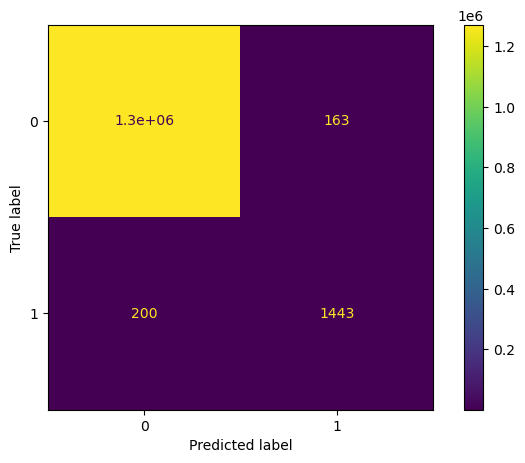

********


In [8]:
import pandas
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
dtree = DecisionTreeClassifier()
evaluating_model(dtree,y_test)

[Text(0.9464025482183158, 0.9857142857142858, 'step <= 3.338\ngini = 0.003\nsamples = 5090096\nvalue = [5083526, 6570]'),
 Text(0.9454547370696872, 0.9571428571428572, 'var <= 3.17\ngini = 0.002\nsamples = 5089857\nvalue = [5083526, 6331]'),
 Text(0.8984327251316141, 0.9285714285714286, 'type <= 1.473\ngini = 0.002\nsamples = 5077177\nvalue = [5071703, 5474]'),
 Text(0.8498836363896425, 0.9, 'amount <= 1.197\ngini = 0.001\nsamples = 4621708\nvalue = [4619384, 2324]'),
 Text(0.7765399758182044, 0.8714285714285714, 'amount <= 0.952\ngini = 0.001\nsamples = 4620865\nvalue = [4618803, 2062]'),
 Text(0.6345917104184716, 0.8428571428571429, 'step <= 1.16\ngini = 0.001\nsamples = 4618663\nvalue = [4616712, 1951]'),
 Text(0.39011218320291674, 0.8142857142857143, 'var <= 0.881\ngini = 0.001\nsamples = 4350060\nvalue = [4348917, 1143]'),
 Text(0.1532917202355829, 0.7857142857142857, 'type <= -0.566\ngini = 0.0\nsamples = 4285168\nvalue = [4284241, 927]'),
 Text(0.15234390908695428, 0.75714285714

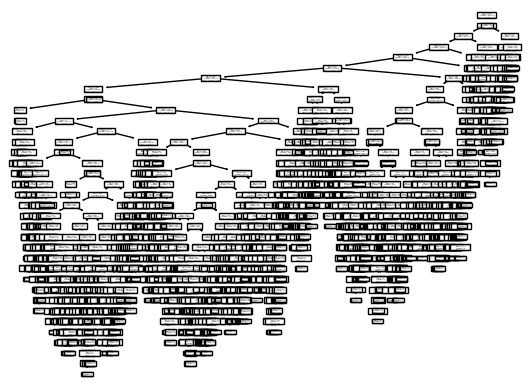

In [11]:
tree.plot_tree(dtree, feature_names=list(x.columns))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
base_classifier = DecisionTreeClassifier(max_depth=1)

clf = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=0)
evaluating_model(clf,y_test)

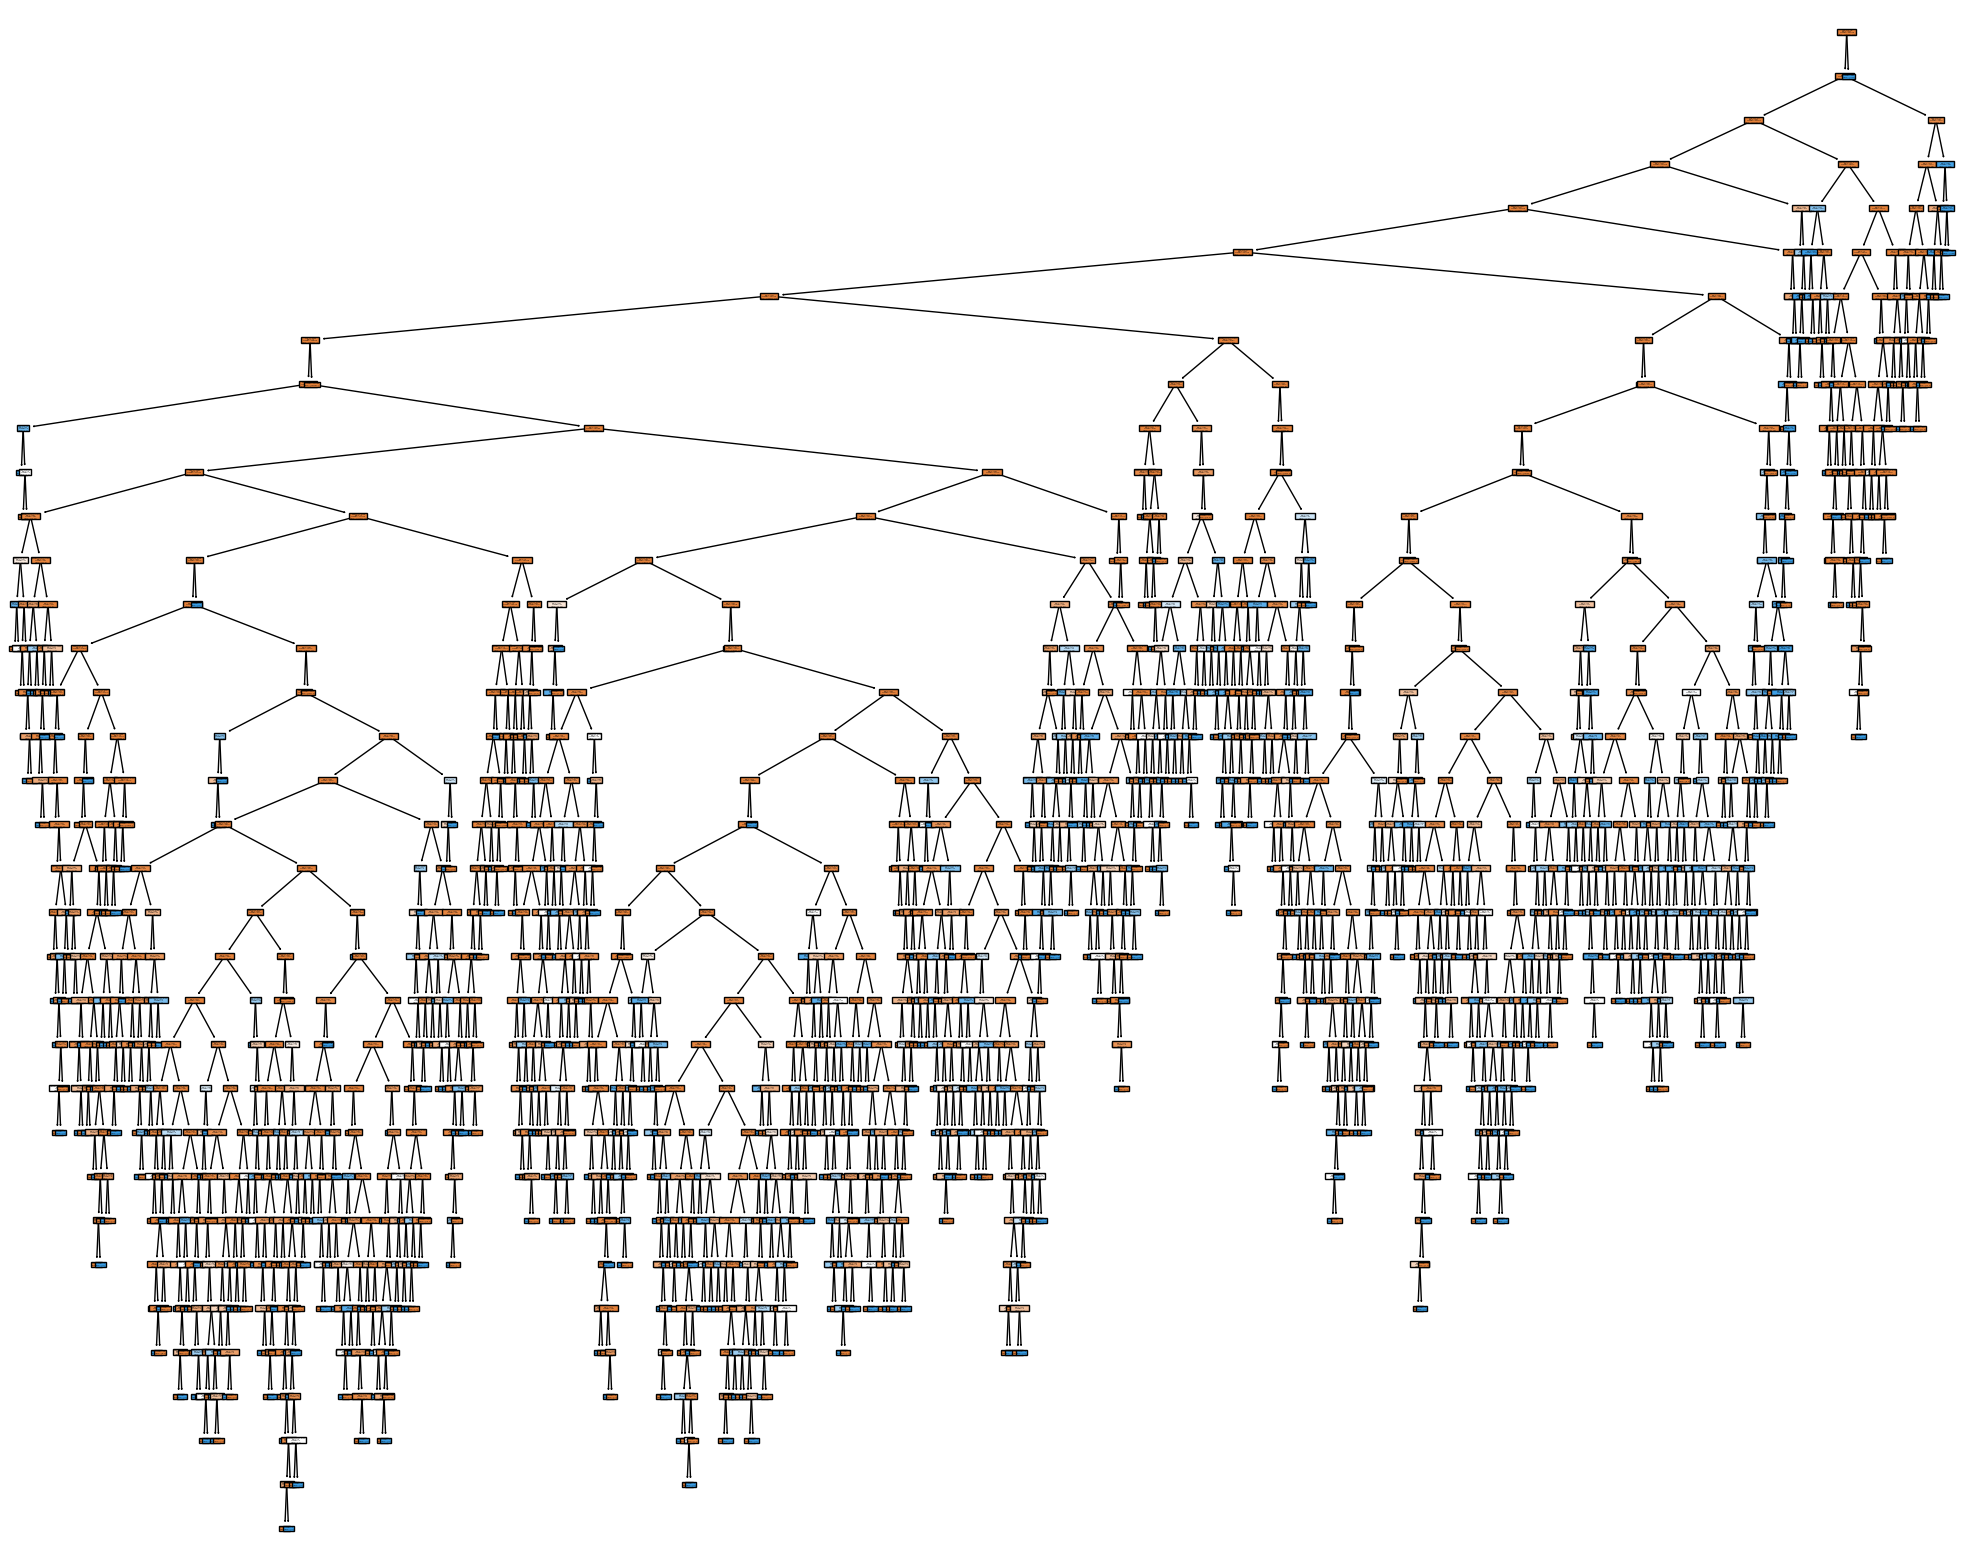

In [12]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtree, 
                   feature_names=list(x.columns),  
                   filled=True)

# randomforest parameter tuning

In [ ]:
param = {
    'n_estimators': [1,5,10,50,100,200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid_cv_for = GridSearchCV(model6, param_grid=param)
grid_cv_for.fit(x_train, y_train)

In [ ]:
grid_cv.best_params_

In [ ]:
model7 = RandomForestClassifier(n_estimators= 5)

In [5]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.05, random_state=0)
evaluating_model(clf,y_test)

name of the model ---  
IsolationForest(contamination=0.05, random_state=0)
*****predicting values****
Training time:  30.33259630203247
Testing time:  6.264878988265991

******evaluating model ****
accuracy = 0.0

*********micro  *******


TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[-1  1] and y_pred=['no' 'yes']. Make sure that the predictions provided by the classifier coincides with the true labels.